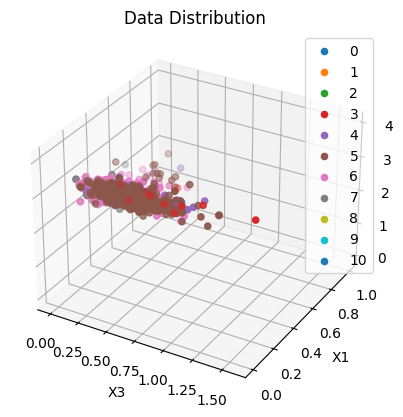

The Average Expected Risk is 0.3240594079151414
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.00146843
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.16981132 0.02496329
  0.01567398 0.00502513 0.         0.         0.        ]
 [0.         0.         0.         0.         0.41509434 0.56975037
  0.17711599 0.01507538 0.         0.         0.        ]
 [0.         0.         0.         0.         0.39622642 0.38913363
  0.70219436 0.53768844 0.16666667 0.         0.        ]
 [0.         0.         0.         0.         0.01886792 0.01468429
  0.0846395  0.36180905 0.

In [1]:
import random
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from numpy import linalg as LA

# compute mean and covariance
def compute_mean_and_covariance(No_samples, No_features, class_labels, No_labels):
    unq_ls = len(np.unique(class_labels))
    mean = np.zeros( [No_labels, No_features] )
    covariance = np.zeros( [No_labels, No_features, No_features] )
    
#     for i, cls_i in enumerate(np.unique(class_labels)):
#         mean[i, :] = np.mean(df[df['quality'] == cls_i].drop(columns=['quality']), axis = 0)
#         covariance[i, :, :] = np.cov(df[(df['quality'] == cls_i)].drop(columns=['quality']), rowvar = False)
#         covariance[i, :, :] += (0.00000005) * ((np.trace(covariance[i, :, :])) / LA.matrix_rank(covariance[i, :, :])) * np.eye(No_features)
    for i in range(No_labels):
        mean[i, :] = np.mean(df[df['quality'] == i].drop(columns=['quality']), axis = 0)
        
        if (i not in class_labels):
            covariance[i, :, :] = np.eye(No_features)
        else:
            covariance[i, :, :] = np.cov(df[df['quality'] == i].drop(columns=['quality']), rowvar = False)
            covariance[i, :, :] += (0.00000005) * ((np.trace(covariance[i, :, :]))/LA.matrix_rank(covariance[i, :, :])) * np.eye(No_features)
            
    return mean, covariance

# compute class condtional pdf
def compute_class_conditional_pdf(class_labels, No_labels, No_samples, mean, covariance_matrix):
    P_x_given_L = np.zeros(shape = [No_labels, No_samples])
    unq_ls = np.unique(class_labels)
    for i in unq_ls:
        P_x_given_L[i, :] = multivariate_normal.pdf(df.drop(columns = ['quality']), mean[i, :], covariance_matrix[i, :,:]) 
    return P_x_given_L

# compute class priors based on sample count
def class_priors(No_labels, class_labels, No_samples):
    priors = np.zeros(shape = [11, 1])
    for i in range(0, No_labels):
        priors[i] = (np.size(class_labels[np.where((class_labels == i))])) / No_samples
    return priors

# compute Confusion Matrix
def compute_confusion_matrix (No_labels, class_labels):
    cm = np.zeros(shape = [No_labels, No_labels])
    for i in range(No_labels):
        for j in range(No_labels):
            if j in class_labels and i in class_labels:
                cm[i, j] = (np.size(np.where((i == Decision) & (j == class_labels)))) / np.size(np.where(class_labels == j))
    return cm

# Import Dataset
df = pd.read_csv(r'C:\Users\Shiva Kumar Dande\Downloads\winequality-red.csv')
df = df.dropna()
Data = df.to_numpy()
#print(Data)
No_Classes = 11

rows, columns = np.shape(df)
No_samples = rows
No_features = columns - 1
No_labels = 11
df.dropna(inplace=True)

class_labels = df['quality']
class_labels = np.array(class_labels)

# Plot Data Distribution
fig = plt.figure()
ax = plt.axes(projection = "3d")
for i in range(No_labels):
    ax.scatter(Data[(class_labels==i),1],Data[(class_labels==i),4],Data[(class_labels==i),8], label = i)
plt.xlabel('X3')
plt.ylabel('X1')
ax.set_zlabel('X2')
ax.legend()
plt.title('Data Distribution')
plt.show()

loss_matrix = np.ones([No_labels, No_labels]) - np.eye(No_labels)
mean, covariance = compute_mean_and_covariance(No_samples, No_features, class_labels, No_labels)
pdf = compute_class_conditional_pdf(class_labels, No_labels, No_samples, mean, covariance)
p = class_priors(No_labels, class_labels, No_samples)

# Compute Class Posteriors using priors and class conditional PDF
P_x = np.matmul(np.transpose(p), pdf)
class_posteriors = (pdf * (np.matlib.repmat(p, 1, No_samples))) / np.matlib.repmat(P_x, No_labels, 1)

# Evaluate Expected risk and decisions based on minimum risk
expected_risk = np.matmul(loss_matrix, class_posteriors)
Decision = np.argmin(expected_risk, axis = 0)
avg_exp_risk = np.sum(np.min(expected_risk, axis = 0)) / No_samples
print(f'The Average Expected Risk is {avg_exp_risk}')
cm = compute_confusion_matrix (No_labels, class_labels)
print(cm)